In [35]:

import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/datasets/Phising_dataset_predict.csv')

# Display the first few rows of the dataframe
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Unnamed: 0  NumDots  UrlLength  AtSymbol  NumDash  NumPercent  \
0           0        3         72         0        0           0   
1           1        3        144         0        0           0   
2           2        3         58         0        0           0   
3           3        3         79         0        1           0   
4           4        3         46         0        0           0   

   NumQueryComponents  IpAddress  HttpsInHostname  PathLevel  PathLength  \
0                   0          0                0          5          44   
1                   2          0                0          3          16   
2                   0          0                0          2          24   
3                   0          0                0          6          50   
4                   0          0                0          4          29   

   Nu

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [37]:
print("\nChecking for NaN values in the original DataFrame before any processing:")
nan_counts = df.isnull().sum()
print(nan_counts[nan_counts > 0]) # Only print columns with NaNs

# If there are NaNs, decide how to handle them.
# For a target column like 'Phising'/'Phishing', dropping rows with NaNs is usually the safest.
# For features, you might drop rows or impute.
if nan_counts.sum() > 0:
    print("\nNaN values detected. Dropping rows with any NaN values for simplicity.")
    original_rows = df.shape[0]
    df.dropna(inplace=True)
    print(f"Dropped {original_rows - df.shape[0]} rows containing NaN values.")
    print(f"New dataset shape: {df.shape}")
# Check for the exact column name (handle potential typos)
print("Column names in the dataset:")
print(df.columns.tolist())

# Handle the column name variation (Phising vs Phishing)
if 'Phising' in df.columns:
    target_column = 'Phising'
elif 'Phishing' in df.columns:
    target_column = 'Phishing'
else:
    # If neither exists, find the column that looks like the target
    target_column = [col for col in df.columns if 'phish' in col.lower()][0]

print(f"Target column identified: {target_column}")


Checking for NaN values in the original DataFrame before any processing:
Phising    32520
dtype: int64

NaN values detected. Dropping rows with any NaN values for simplicity.
Dropped 32520 rows containing NaN values.
New dataset shape: (630071, 13)
Column names in the dataset:
['Unnamed: 0', 'NumDots', 'UrlLength', 'AtSymbol', 'NumDash', 'NumPercent', 'NumQueryComponents', 'IpAddress', 'HttpsInHostname', 'PathLevel', 'PathLength', 'NumNumericChars', 'Phising']
Target column identified: Phising


In [38]:
# Display data types and non-null counts
print("\nDataset Information:")
print(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 630071 entries, 0 to 662590
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          630071 non-null  int64  
 1   NumDots             630071 non-null  int64  
 2   UrlLength           630071 non-null  int64  
 3   AtSymbol            630071 non-null  int64  
 4   NumDash             630071 non-null  int64  
 5   NumPercent          630071 non-null  int64  
 6   NumQueryComponents  630071 non-null  int64  
 7   IpAddress           630071 non-null  int64  
 8   HttpsInHostname     630071 non-null  int64  
 9   PathLevel           630071 non-null  int64  
 10  PathLength          630071 non-null  int64  
 11  NumNumericChars     630071 non-null  int64  
 12  Phising             630071 non-null  float64
dtypes: float64(1), int64(12)
memory usage: 67.3 MB
None


In [39]:
# Provide descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
          Unnamed: 0       NumDots      UrlLength       AtSymbol  \
count  630071.000000  630071.00000  630071.000000  630071.000000   
mean   325331.908039       2.16758      60.445577       0.002231   
std    190553.398837       1.49229      45.266911       0.054520   
min         0.000000       0.00000       1.000000       0.000000   
25%    161122.500000       1.00000      32.000000       0.000000   
50%    322449.000000       2.00000      47.000000       0.000000   
75%    483976.500000       3.00000      78.000000       0.000000   
max    662590.000000      42.00000    2175.000000      10.000000   

             NumDash     NumPercent  NumQueryComponents      IpAddress  \
count  630071.000000  630071.000000       630071.000000  630071.000000   
mean        1.608071       0.381792            0.232147       0.000962   
std         3.023197       4.113050            0.473905       0.030998   
min         0.000000       0.000000            0.000000       0.00

In [40]:
# Separate features from the target variable
print("Original dataset shape:", df.shape)
print("Features before preprocessing:", df.columns.tolist())

# Store the true labels for later comparison
true_labels = df[target_column].copy()
print(f"\nTrue label distribution:")
print(f"Phishing URLs (1.0): {sum(true_labels == 1.0)}")
print(f"Legitimate URLs (0.0): {sum(true_labels == 0.0)}")

# Remove the target column from features
features_df = df.drop(target_column, axis=1)
print(f"\nFeatures after removing target column: {features_df.columns.tolist()}")
print("Feature matrix shape:", features_df.shape)

Original dataset shape: (630071, 13)
Features before preprocessing: ['Unnamed: 0', 'NumDots', 'UrlLength', 'AtSymbol', 'NumDash', 'NumPercent', 'NumQueryComponents', 'IpAddress', 'HttpsInHostname', 'PathLevel', 'PathLength', 'NumNumericChars', 'Phising']

True label distribution:
Phishing URLs (1.0): 100011
Legitimate URLs (0.0): 530060

Features after removing target column: ['Unnamed: 0', 'NumDots', 'UrlLength', 'AtSymbol', 'NumDash', 'NumPercent', 'NumQueryComponents', 'IpAddress', 'HttpsInHostname', 'PathLevel', 'PathLength', 'NumNumericChars']
Feature matrix shape: (630071, 12)


In [41]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
features_scaled = scaler.fit_transform(features_df)
print("Features successfully scaled!")
print(f"Scaled features shape: {features_scaled.shape}")

# Convert back to DataFrame for easier handling
features_scaled_df = pd.DataFrame(features_scaled, columns=features_df.columns)
print("\nFirst 5 rows of scaled features:")
print(features_scaled_df.head())

# Verify scaling (mean should be ~0, std should be ~1)
print("\nScaling verification:")
print("Means (should be ~0):", features_scaled_df.mean().round(10))
print("Standard deviations (should be ~1):", features_scaled_df.std().round(3))

Features successfully scaled!
Scaled features shape: (630071, 12)

First 5 rows of scaled features:
   Unnamed: 0   NumDots  UrlLength  AtSymbol   NumDash  NumPercent  \
0   -1.707302  0.557815   0.255251  -0.04093 -0.531911   -0.092825   
1   -1.707297  0.557815   1.845818  -0.04093 -0.531911   -0.092825   
2   -1.707291  0.557815  -0.054026  -0.04093 -0.531911   -0.092825   
3   -1.707286  0.557815   0.409890  -0.04093 -0.201135   -0.092825   
4   -1.707281  0.557815  -0.319120  -0.04093 -0.531911   -0.092825   

   NumQueryComponents  IpAddress  HttpsInHostname  PathLevel  PathLength  \
0           -0.489859  -0.031028        -0.125547   1.329129    0.080777   
1            3.730395  -0.031028        -0.125547   0.101770   -0.858407   
2           -0.489859  -0.031028        -0.125547  -0.511910   -0.590069   
3           -0.489859  -0.031028        -0.125547   1.942809    0.282031   
4           -0.489859  -0.031028        -0.125547   0.715450   -0.422357   

   NumNumericChars  
0

In [42]:
# Initialize and train K-Means with k=2
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit the model and get cluster assignments
cluster_labels = kmeans.fit_predict(features_scaled)

print(f"K-Means clustering completed with k={optimal_k}")
print(f"Cluster assignments: {cluster_labels}")
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")

# Get unique clusters and their counts
unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
print(f"\nCluster distribution:")
for cluster, count in zip(unique_clusters, cluster_counts):
    print(f"Cluster {cluster}: {count} URLs")

K-Means clustering completed with k=2
Cluster assignments: [1 0 1 ... 1 1 1]
Cluster centers shape: (2, 12)

Cluster distribution:
Cluster 0: 138728 URLs
Cluster 1: 491343 URLs


In [43]:
# Initialize and train K-Means with k=2
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fit the model and get cluster assignments
cluster_labels = kmeans.fit_predict(features_scaled)

print(f"K-Means clustering completed with k={optimal_k}")
print(f"Cluster assignments: {cluster_labels}")
print(f"Cluster centers shape: {kmeans.cluster_centers_.shape}")

# Get unique clusters and their counts
unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
print(f"\nCluster distribution:")
for cluster, count in zip(unique_clusters, cluster_counts):
    print(f"Cluster {cluster}: {count} URLs")

K-Means clustering completed with k=2
Cluster assignments: [1 0 1 ... 1 1 1]
Cluster centers shape: (2, 12)

Cluster distribution:
Cluster 0: 138728 URLs
Cluster 1: 491343 URLs


In [44]:
# Add cluster labels to the original DataFrame for comparison
df_with_clusters = df.copy()
df_with_clusters['Predicted_Cluster'] = cluster_labels

print("Sample of data with predicted clusters:")
print(df_with_clusters[['UrlLength', 'NumDots', 'IpAddress', 'Phising', 'Predicted_Cluster']].head(10))

Sample of data with predicted clusters:
   UrlLength  NumDots  IpAddress  Phising  Predicted_Cluster
0         72        3          0      1.0                  1
1        144        3          0      1.0                  0
2         58        3          0      1.0                  1
3         79        3          0      1.0                  0
4         46        3          0      1.0                  1
5         42        3          0      1.0                  1
6         60        2          0      1.0                  1
7         30        1          0      1.0                  1
8         76        8          0      1.0                  1
9         46        2          0      1.0                  1


In [45]:
# Create cross-tabulation between predicted clusters and true labels
crosstab = pd.crosstab(cluster_labels, true_labels, margins=True)
print("Cross-tabulation: Predicted Clusters vs True Labels")
print("Rows: Predicted Clusters, Columns: True Labels (0.0=Legitimate, 1.0=Phishing)")
print(crosstab)

# Calculate the accuracy of cluster assignment
# We need to determine which cluster corresponds to which label
cluster_0_phishing = crosstab.loc[0, 1.0]
cluster_0_legitimate = crosstab.loc[0, 0.0]
cluster_1_phishing = crosstab.loc[1, 1.0]
cluster_1_legitimate = crosstab.loc[1, 0.0]

print(f"\nCluster 0: {cluster_0_phishing} phishing, {cluster_0_legitimate} legitimate")
print(f"Cluster 1: {cluster_1_phishing} phishing, {cluster_1_legitimate} legitimate")

# Determine the better mapping
if cluster_0_phishing > cluster_0_legitimate:
    print("\nCluster 0 appears to represent PHISHING URLs")
    print("Cluster 1 appears to represent LEGITIMATE URLs")
    phishing_cluster = 0
    legitimate_cluster = 1
else:
    print("\nCluster 0 appears to represent LEGITIMATE URLs")
    print("Cluster 1 appears to represent PHISHING URLs")
    phishing_cluster = 1
    legitimate_cluster = 0

Cross-tabulation: Predicted Clusters vs True Labels
Rows: Predicted Clusters, Columns: True Labels (0.0=Legitimate, 1.0=Phishing)
Phising     0.0     1.0     All
row_0                          
0        128046   10682  138728
1        402014   89329  491343
All      530060  100011  630071

Cluster 0: 10682 phishing, 128046 legitimate
Cluster 1: 89329 phishing, 402014 legitimate

Cluster 0 appears to represent LEGITIMATE URLs
Cluster 1 appears to represent PHISHING URLs


In [46]:
# Calculate external validation metrics
# First, we need to map cluster labels to true labels for proper comparison
mapped_labels = np.where(cluster_labels == phishing_cluster, 1, 0)

# Calculate metrics
ari = adjusted_rand_score(true_labels, cluster_labels)
homogeneity = homogeneity_score(true_labels, cluster_labels)
completeness = completeness_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)

print("External Validation Metrics:")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Homogeneity Score: {homogeneity:.3f}")
print(f"Completeness Score: {completeness:.3f}")
print(f"V-Measure Score: {v_measure:.3f}")

print("\nMetric Interpretations:")
print("- ARI: Measures similarity between clusterings (1.0 = perfect, 0.0 = random)")
print("- Homogeneity: Whether each cluster contains only members of a single class")
print("- Completeness: Whether all members of a given class are assigned to the same cluster")
print("- V-Measure: Harmonic mean of homogeneity and completeness")

# Calculate simple accuracy
correct_predictions = sum(mapped_labels == true_labels)
accuracy = correct_predictions / len(true_labels)
print(f"\nSimple Accuracy: {accuracy:.3f} ({correct_predictions}/{len(true_labels)})")

External Validation Metrics:
Adjusted Rand Index (ARI): -0.058
Homogeneity Score: 0.018
Completeness Score: 0.015
V-Measure Score: 0.017

Metric Interpretations:
- ARI: Measures similarity between clusterings (1.0 = perfect, 0.0 = random)
- Homogeneity: Whether each cluster contains only members of a single class
- Completeness: Whether all members of a given class are assigned to the same cluster
- V-Measure: Harmonic mean of homogeneity and completeness

Simple Accuracy: 0.345 (217375/630071)


PCA explained variance ratio: [0.20538601 0.14187659]
Total variance explained: 0.347


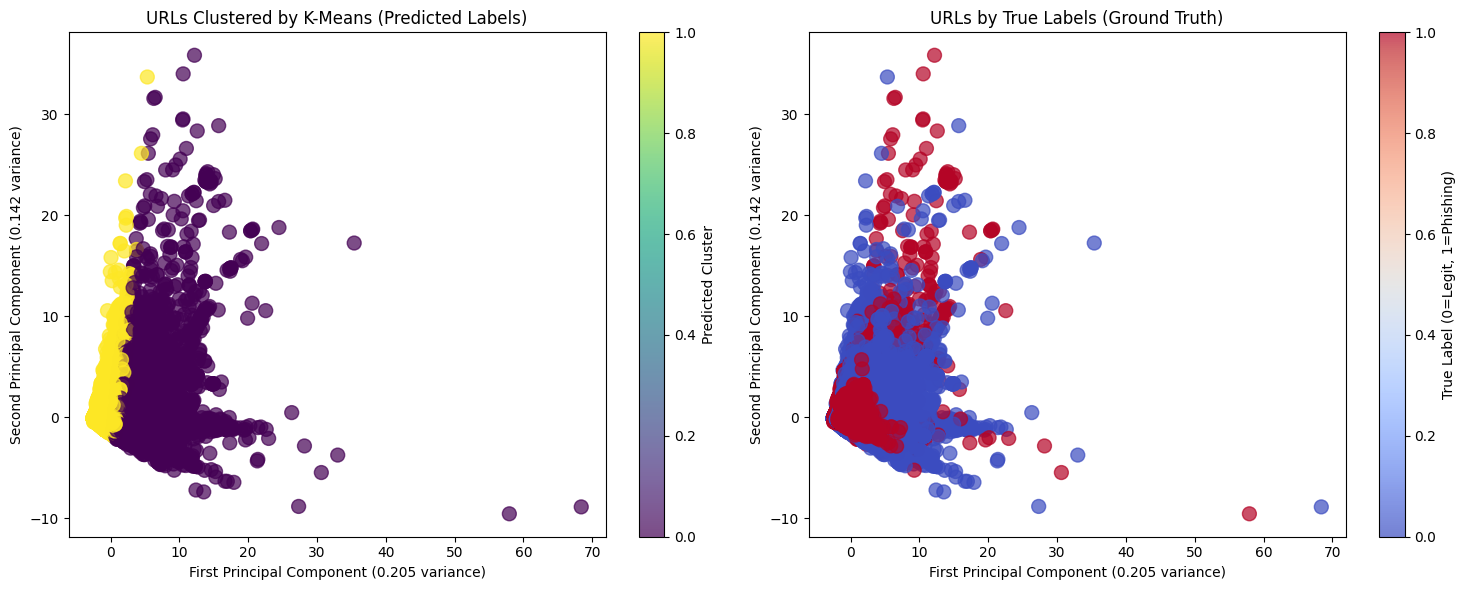

In [47]:
# Apply PCA to reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Colored by predicted clusters
scatter1 = ax1.scatter(features_pca[:, 0], features_pca[:, 1],
                      c=cluster_labels, cmap='viridis', s=100, alpha=0.7)
ax1.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.3f} variance)')
ax1.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.3f} variance)')
ax1.set_title('URLs Clustered by K-Means (Predicted Labels)')
plt.colorbar(scatter1, ax=ax1, label='Predicted Cluster')

# Plot 2: Colored by true labels
scatter2 = ax2.scatter(features_pca[:, 0], features_pca[:, 1],
                      c=true_labels, cmap='coolwarm', s=100, alpha=0.7)
ax2.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.3f} variance)')
ax2.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.3f} variance)')
ax2.set_title('URLs by True Labels (Ground Truth)')
plt.colorbar(scatter2, ax=ax2, label='True Label (0=Legit, 1=Phishing)')

plt.tight_layout()
plt.show()

Feature importance based on cluster center differences:
               Feature  Cluster_0_Center  Cluster_1_Center  \
10          PathLength          1.302825         -0.369122   
4              NumDash          1.206206         -0.341747   
2            UrlLength          1.030128         -0.291860   
9            PathLevel          0.915335         -0.259336   
11     NumNumericChars          0.368230         -0.104329   
1              NumDots          0.264398         -0.074910   
5           NumPercent          0.260615         -0.073839   
8      HttpsInHostname          0.128712         -0.036467   
6   NumQueryComponents         -0.095194          0.026971   
3             AtSymbol          0.074578         -0.021130   
7            IpAddress          0.056405         -0.015981   
0           Unnamed: 0         -0.024740          0.007009   

    Absolute_Difference  
10             1.671947  
4              1.547953  
2              1.321988  
9              1.174671  
11     

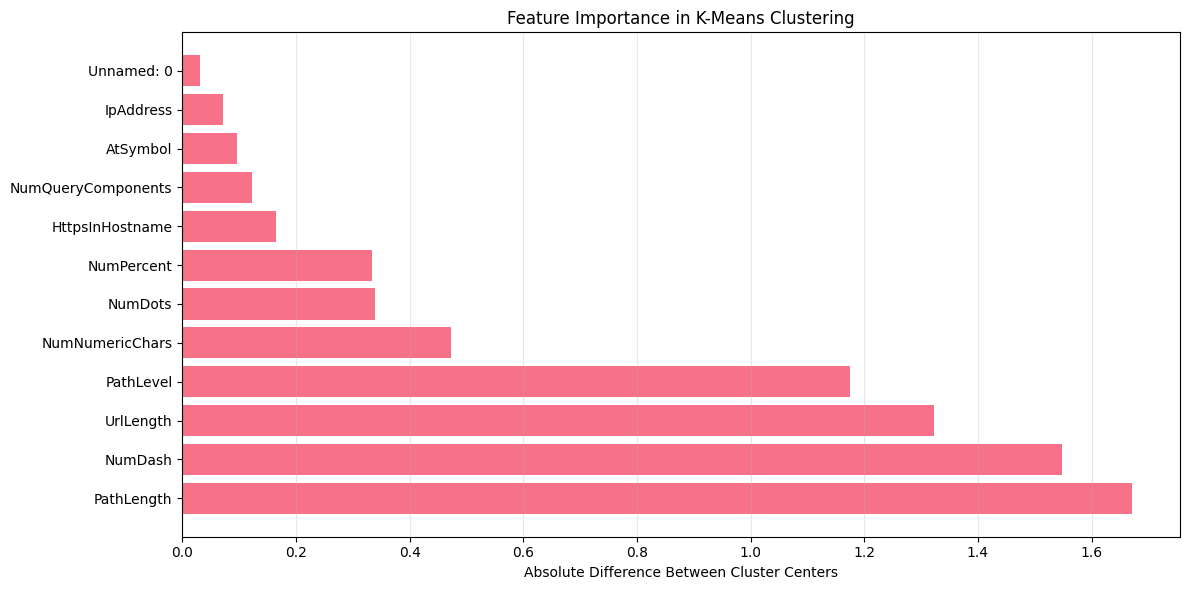

In [48]:
# Analyze which features contribute most to cluster separation
cluster_centers = kmeans.cluster_centers_
feature_names = features_df.columns

# Calculate the difference between cluster centers
center_diff = np.abs(cluster_centers[0] - cluster_centers[1])

# Create a DataFrame for better visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Cluster_0_Center': cluster_centers[0],
    'Cluster_1_Center': cluster_centers[1],
    'Absolute_Difference': center_diff
}).sort_values('Absolute_Difference', ascending=False)

print("Feature importance based on cluster center differences:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute_Difference'])
plt.xlabel('Absolute Difference Between Cluster Centers')
plt.title('Feature Importance in K-Means Clustering')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


--- Scatter Plot of Clusters using Most Important Features ---


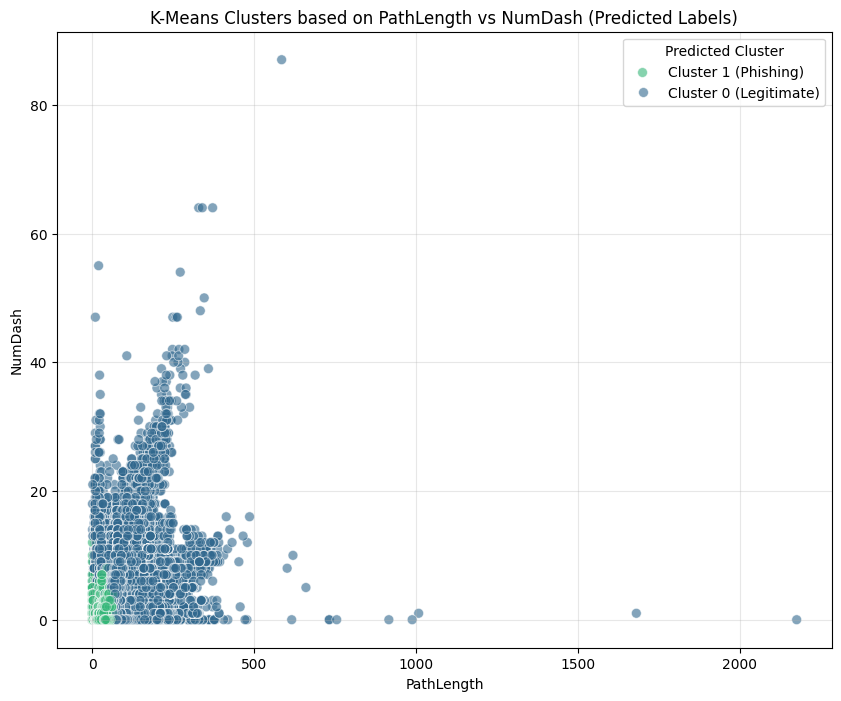

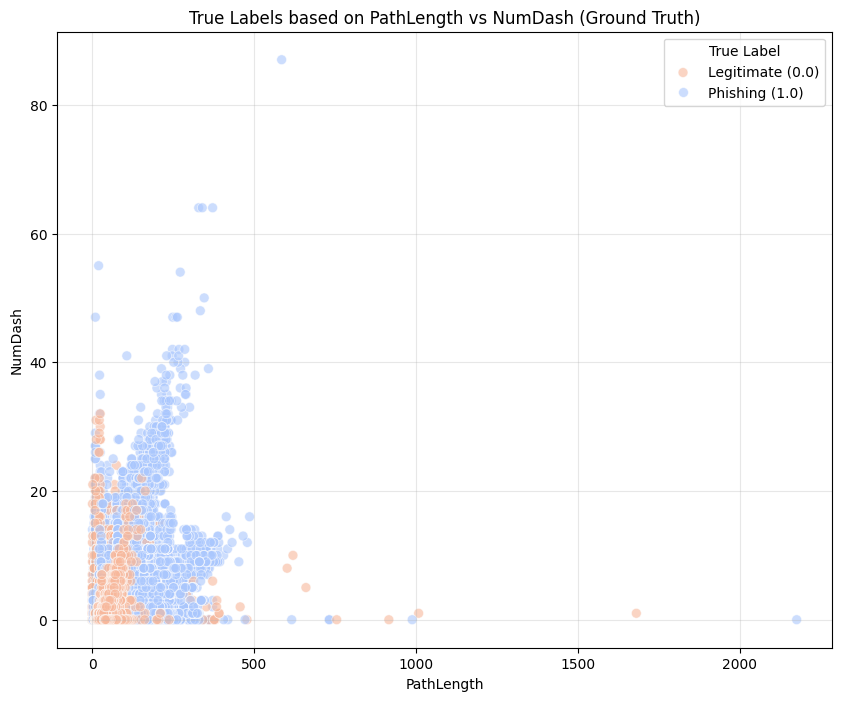

In [49]:
# --- NEW CODE BLOCK: Scatter Plot of Clusters using Important Features ---

print("\n--- Scatter Plot of Clusters using Most Important Features ---")

# Assuming 'feature_importance' DataFrame has been created from Section 10
# (which calculates differences between cluster centers)
# Get the top 2 most important features based on absolute difference
if len(feature_importance) >= 2:
    feature1 = feature_importance['Feature'].iloc[0]
    feature2 = feature_importance['Feature'].iloc[1]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_with_clusters,
        x=feature1,
        y=feature2,
        hue='Predicted_Cluster',
        palette='viridis', # Consistent with predicted clusters
        s=50, # Marker size
        alpha=0.6 # Transparency
    )
    plt.title(f'K-Means Clusters based on {feature1} vs {feature2} (Predicted Labels)')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title='Predicted Cluster', labels=[f'Cluster {phishing_cluster} (Phishing)', f'Cluster {legitimate_cluster} (Legitimate)'])
    plt.grid(True, alpha=0.3)
    plt.show()

    # Optional: Compare with True Labels using the same features
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df_with_clusters,
        x=feature1,
        y=feature2,
        hue=target_column, # Use the actual target column for true labels
        palette='coolwarm', # Consistent with true labels
        s=50,
        alpha=0.6
    )
    plt.title(f'True Labels based on {feature1} vs {feature2} (Ground Truth)')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend(title='True Label', labels=['Legitimate (0.0)', 'Phishing (1.0)'])
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("Not enough features to create a 2D scatter plot based on feature importance.")


--- Visualizing Feature Distributions by Cluster ---


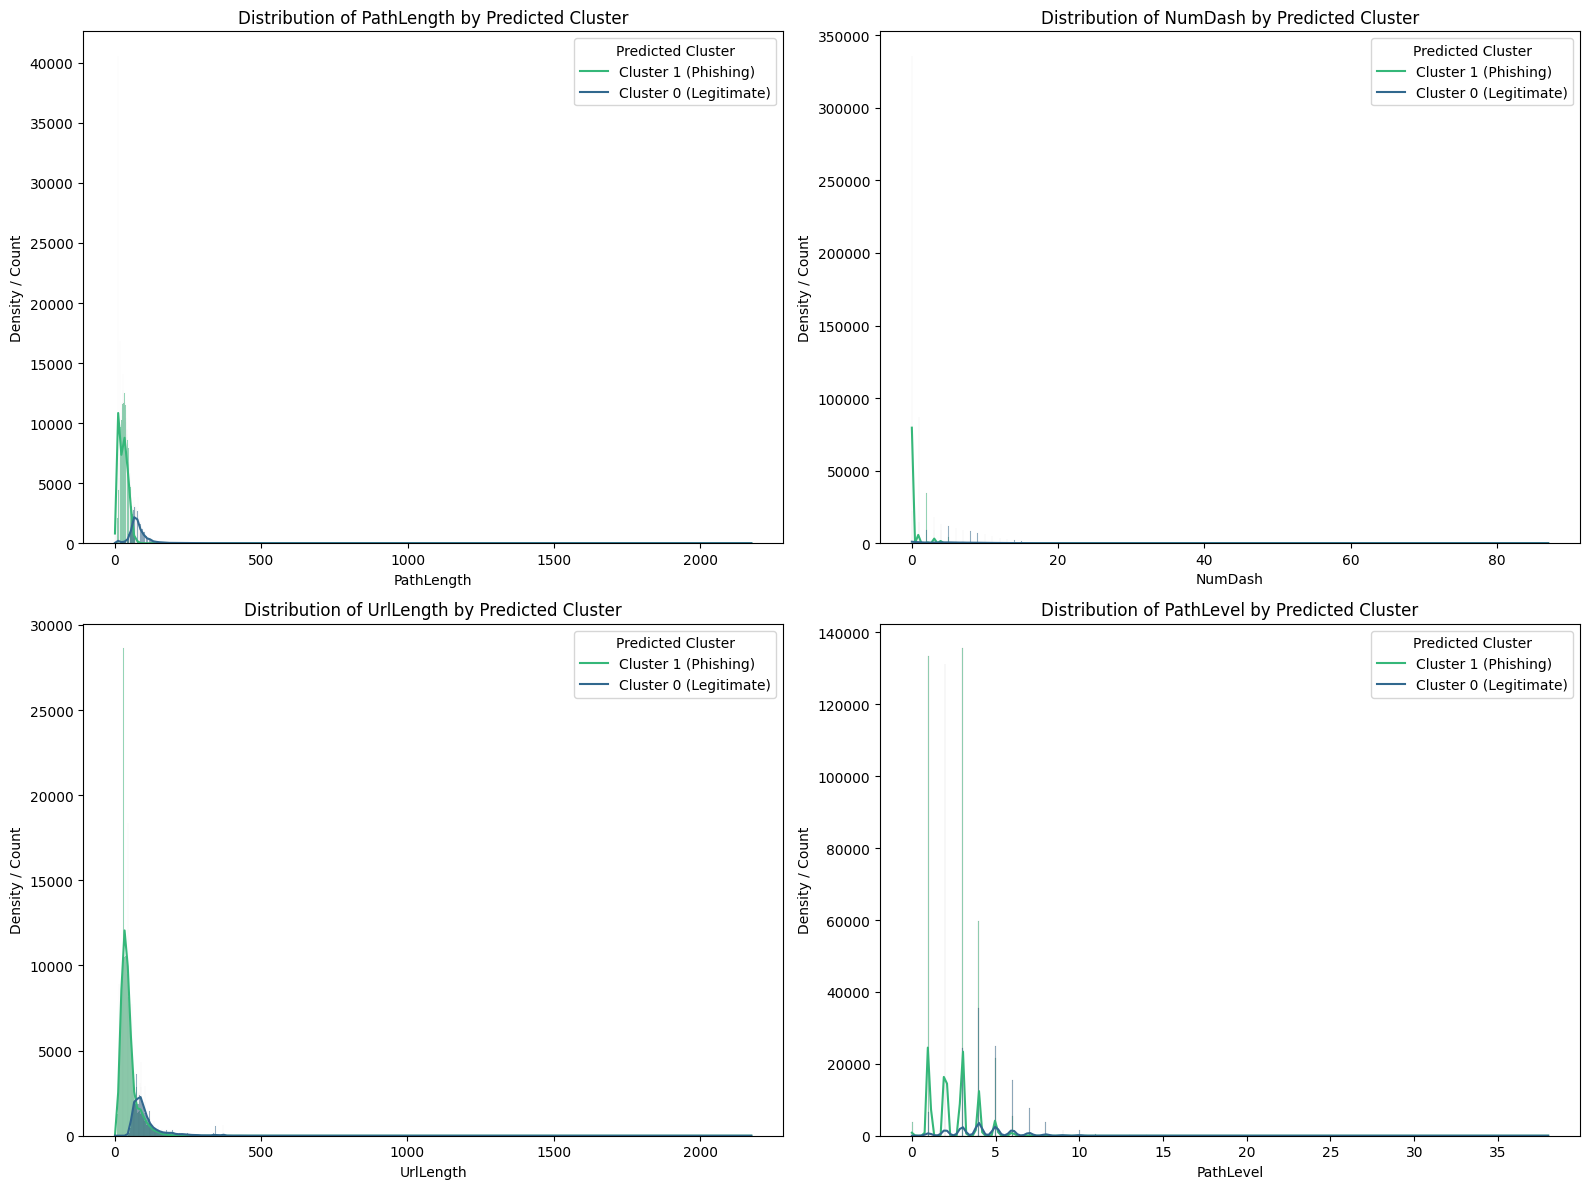

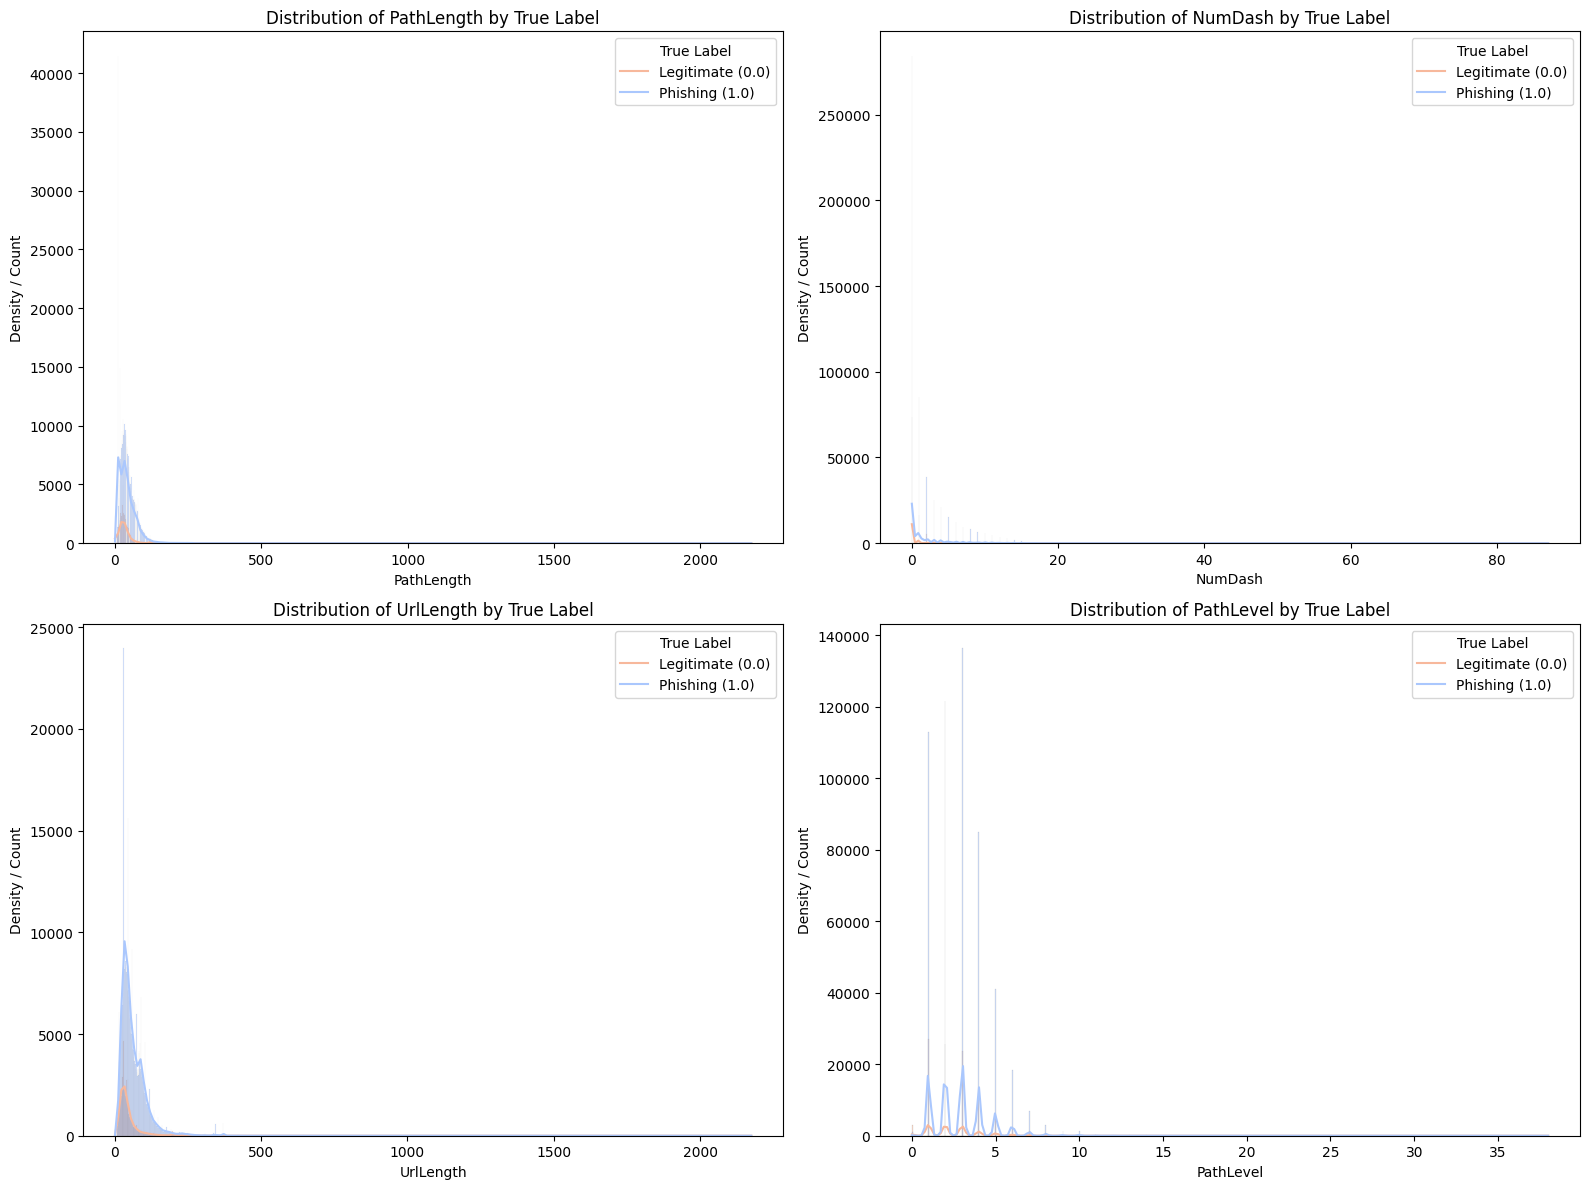

In [50]:
# --- NEW CODE BLOCK: Feature Distributions by Cluster ---

print("\n--- Visualizing Feature Distributions by Cluster ---")

# First, ensure df_with_clusters has been created and populated correctly
# If you run this block independently, ensure 'df_with_clusters' exists
# and 'Predicted_Cluster' column is present.
# It was created in your notebook in Section 6:
# df_with_clusters = df.copy()
# df_with_clusters['Predicted_Cluster'] = cluster_labels

# Also, ensure 'phishing_cluster' and 'legitimate_cluster' are defined from Section 6
# phishing_cluster = ...
# legitimate_cluster = ...


# Select a few important features to visualize based on your 'feature_importance' analysis
# (e.g., from the output of Section 10 after you run it)
# For example, let's pick top 4 from your example output
top_features_to_plot = feature_importance['Feature'].head(4).tolist()

plt.figure(figsize=(16, 12))
for i, feature in enumerate(top_features_to_plot):
    plt.subplot(2, 2, i + 1) # Adjust subplot grid based on number of features
    sns.histplot(data=df_with_clusters, x=feature, hue='Predicted_Cluster', kde=True, palette='viridis', common_norm=False)
    plt.title(f'Distribution of {feature} by Predicted Cluster')
    plt.xlabel(feature)
    plt.ylabel('Density / Count')
    plt.legend(title='Predicted Cluster', labels=[f'Cluster {phishing_cluster} (Phishing)', f'Cluster {legitimate_cluster} (Legitimate)'])
plt.tight_layout()
plt.show()

# You can also do this for the true labels for comparison
plt.figure(figsize=(16, 12))
for i, feature in enumerate(top_features_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=df_with_clusters, x=feature, hue=target_column, kde=True, palette='coolwarm', common_norm=False)
    plt.title(f'Distribution of {feature} by True Label')
    plt.xlabel(feature)
    plt.ylabel('Density / Count')
    plt.legend(title='True Label', labels=['Legitimate (0.0)', 'Phishing (1.0)'])
plt.tight_layout()
plt.show()


--- Box Plots of Important Features by Cluster ---


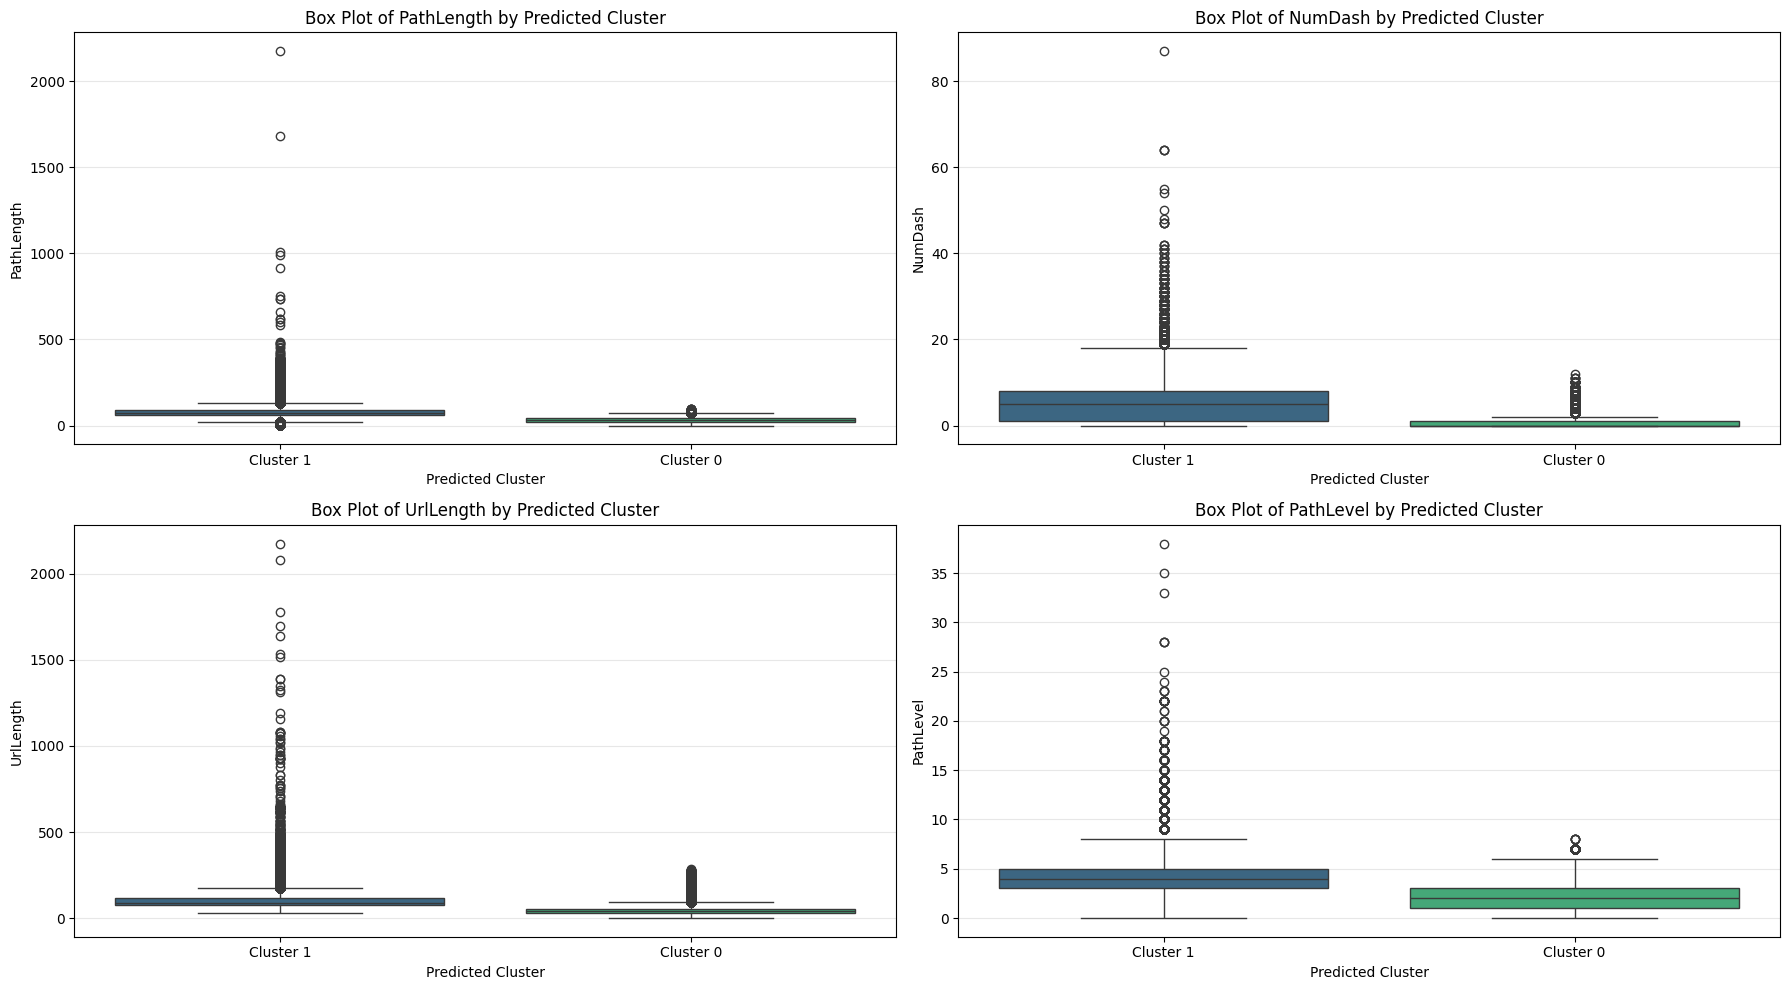

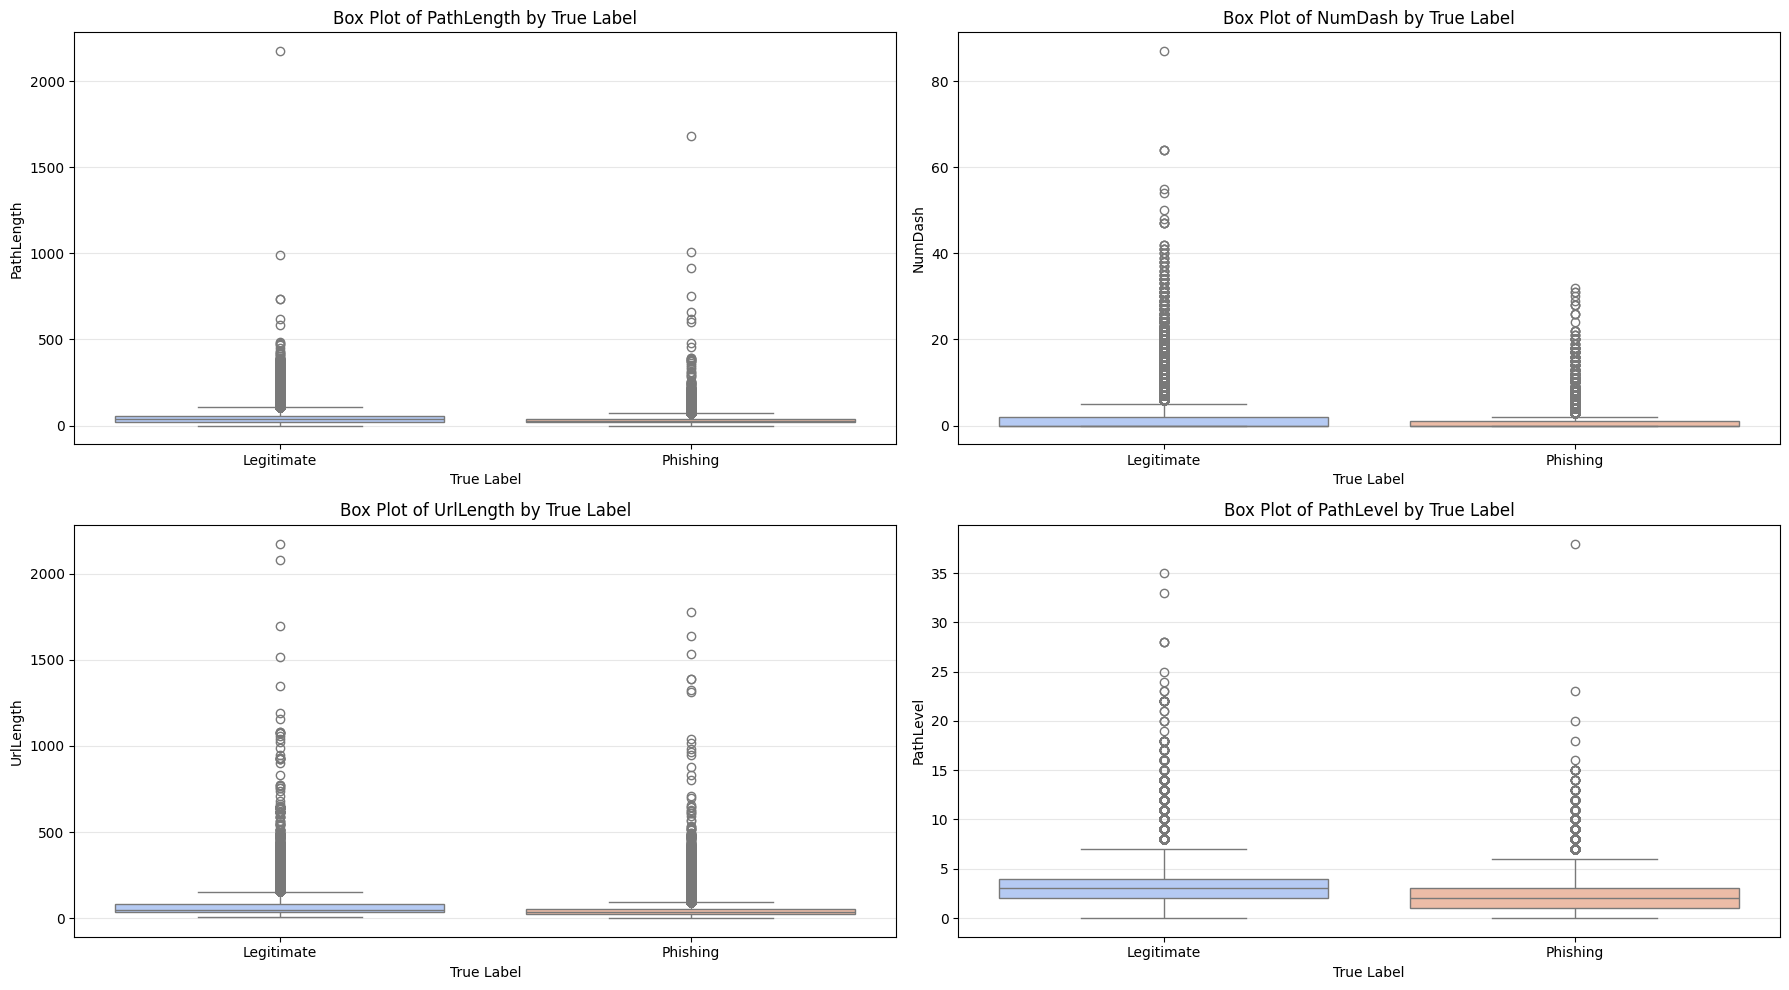

In [51]:
# --- NEW CODE BLOCK: Box Plots of Important Features by Cluster ---

print("\n--- Box Plots of Important Features by Cluster ---")

# Use the same top_features_to_plot as before, or select others
# For example, let's pick top 4 from your example output
top_features_to_plot_bp = feature_importance['Feature'].head(4).tolist()


plt.figure(figsize=(18, 10))
for i, feature in enumerate(top_features_to_plot_bp):
    plt.subplot(2, 2, i + 1) # Adjust subplot grid based on number of features
    sns.boxplot(data=df_with_clusters, x='Predicted_Cluster', y=feature, palette='viridis')
    plt.title(f'Box Plot of {feature} by Predicted Cluster')
    plt.xlabel('Predicted Cluster')
    plt.ylabel(feature)
    plt.xticks(ticks=[0, 1], labels=[f'Cluster {phishing_cluster}', f'Cluster {legitimate_cluster}']) # Label axes clearly
    plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Box Plots for True Labels
plt.figure(figsize=(18, 10))
for i, feature in enumerate(top_features_to_plot_bp):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df_with_clusters, x=target_column, y=feature, palette='coolwarm')
    plt.title(f'Box Plot of {feature} by True Label')
    plt.xlabel('True Label')
    plt.ylabel(feature)
    plt.xticks(ticks=[0, 1], labels=['Legitimate', 'Phishing'])
    plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()